In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os
import sys

from statsmodels.stats.anova import AnovaRM

from utilities import *
from taskSetting import *
from expsInfo import *
from modelSpecificities import *
from funcs_loadData import *

/Users/mingyusong/anaconda3/envs/rule-learning/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Model comparison

In [2]:
def model_comparison(action):

    if action == 'main':

        models = [
            'myopicBayesianNoCost',
            'featureRLwDecayNoCost',
            'inferSerialHypoTesting_CountingRandomSwitchEpsilonNoCost_FlexibleHypoAvg',
            'inferSerialHypoTesting_CountingValueBasedSwitchNoResetDecayEpsilonNoCost_FlexibleHypoAvg',
        ]

        modelLabel = {
            'myopicBayesianNoCost': 'Bayesian rule learning',
            'featureRLwDecayNoCost': 'Feature RL with decay',
            'inferSerialHypoTesting_CountingRandomSwitchEpsilonNoCost_FlexibleHypoAvg': 'Random-switch SHT',
            'inferSerialHypoTesting_CountingValueBasedSwitchNoResetDecayEpsilonNoCost_FlexibleHypoAvg': 'Value-based SHT',
        }

    elif action == 'valueSHT':

        models = [
            'inferSerialHypoTesting_CountingValueBasedSwitchNoResetDecayEpsilonNoCost_FlexibleHypoAvg',
            'inferSerialHypoTesting_CountingDiffThresValueBasedSwitchNoResetDecayEpsilonNoCost_FlexibleHypoAvg',
            'inferSerialHypoTesting_CountingValueBasedSwitchNoResetDecayThresonTestEpsilonNoCost_FlexibleHypoAvg',
            'inferSerialHypoTesting_CountingRandomSwitchEpsilonNoCost_FlexibleHypoAvg',
            'inferSerialHypoTesting_CountingValueBasedSwitchNoResetDecaySelectMoreNoCost_FlexibleHypoAvg',
            'inferSerialHypoTesting_CountingValueBasedSwitchNoResetDecayThresonTestSelectMoreNoCost_FlexibleHypoAvg',
        ]

        refModel = models[0]
        fullModel = models[-1]

        modelLabel = {
            'inferSerialHypoTesting_CountingValueBasedSwitchNoResetDecayEpsilonNoCost_FlexibleHypoAvg': 'Baseline model',
            'inferSerialHypoTesting_CountingDiffThresValueBasedSwitchNoResetDecayEpsilonNoCost_FlexibleHypoAvg': 'Hypothesis testing policy: reward probs     ',
            'inferSerialHypoTesting_CountingValueBasedSwitchNoResetDecayThresonTestEpsilonNoCost_FlexibleHypoAvg': 'Testing hypothesis: sometimes',
            'inferSerialHypoTesting_CountingRandomSwitchEpsilonNoCost_FlexibleHypoAvg': 'Switch policy: random                            ',
            'inferSerialHypoTesting_CountingValueBasedSwitchNoResetDecaySelectMoreNoCost_FlexibleHypoAvg': 'Choice policy: selecting more',
            'inferSerialHypoTesting_CountingValueBasedSwitchNoResetDecayThresonTestSelectMoreNoCost_FlexibleHypoAvg': 'Full model'
        }

        colors = ['C1', 'C2', 'C4', 'C5', 'w'] #, 'C6'

    elif action == 'others':
        models = [
            'featureRLSameEtaNoCost',
            'conjunctionRLNoCost',
            'conjunctionRLNoCostFlexChoice',
            'expertRL',
        ]

        refModel = models[0]
        fullModel = models[-1]

        modelLabel = {
            'featureRLSameEtaNoCost': 'Feature-based RL',
            'conjunctionRLNoCost': 'Conjunction-based RL',
            'conjunctionRLNoCostFlexChoice': 'Conjunction-based RL\n(generalization at choice)',
            'expertRL': 'Expert RL',
        }

    # Load data
    data, workerIds = load_data(expVersion='all', getWorkerIds=True)    

    workerIdList, modelList, negllhList, lik_geomeanList = emptyLists(4)
    for model in models:
        numPars = len(parameterName[model])
        for workerId in workerIds:
            workerIdList.append(workerId)
            modelList.append(model)
            ifFlatPrior = None if 'Bayesian' not in model else False
            fileNameTotal = getFittingCollectFileName(model=model, expVersion=expVersion, ifFlatPrior=ifFlatPrior, fittingAlgorithm=fittingAlgorithm, CV='total')
            if os.path.exists('fittingResultsCollectCV/'+fileNameTotal):
                CVTotal = pd.read_csv('fittingResultsCollectCV/'+fileNameTotal)
                negllh = CVTotal.loc[CVTotal['workerId']==workerId,'negllhTest'].values[0]
                NValidTrials = data[(~data['rt'].isnull())&(data['workerId']==workerId)].shape[0]
                negllhList.append(negllh)
                lik_geomeanList.append(np.exp(-negllh/NValidTrials))
            else:
                negllhList.append(np.nan)
                lik_geomeanList.append(np.nan)
    fittingResults = pd.DataFrame({'workerId': workerIdList, 'model': modelList, 'negllh': negllhList, 'lik_geomean': lik_geomeanList})

    # compare the likelihood per trial of all models (bar plot)
    mean = fittingResults.groupby(['model']).mean().loc[models, 'lik_geomean'].values
    se = fittingResults.groupby(['model']).std().loc[models, 'lik_geomean'] / np.sqrt(len(workerIds))

    if action == 'valueSHT':
        likDiffmean, likDiffse = np.empty(len(models)), np.empty(len(models))
        iM = 0
        for model in models:
            if model != refModel:
                likDiff = fittingResults.loc[fittingResults['model']==model, 'lik_geomean'].values - fittingResults.loc[fittingResults['model']==refModel, 'lik_geomean'].values
                likDiffmean[iM] = np.mean(likDiff)
                likDiffse[iM] = np.std(likDiff) / np.sqrt(len(workerIds))
                iM += 1

    plt.rcParams.update({'font.size': 7.5})
    if action == 'main':
        fig, ax = plt.subplots(1, figsize=(3, 1.8))
    elif action == 'valueSHT':
        fig, ax = plt.subplots(1, figsize=(4, 2))
    else:
        fig, ax = plt.subplots(1, figsize=(3, 1.8))
    iM = 0
    for model in models:
        if action != 'valueSHT':
            ax.barh(iM, mean[iM], color='w', edgecolor='k', xerr=se[iM], error_kw={'elinewidth':1})
            iM += 1
        else:
            if model != refModel:
                ax.barh(iM, likDiffmean[iM], color=colors[iM], edgecolor='k', xerr=likDiffse[iM], error_kw={'elinewidth':1}, alpha=.7 if model != fullModel else 1)
                iM += 1
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')
    ax.spines['left'].set_position(('data', 0))
    ax.set_yticks(np.arange(len(models)))
    ax.set_yticklabels([modelLabel[model] for model in models]) #, rotation=45, horizontalalignment='left'
    ax.set_ylim([-0.7, len(models) - 0.3])
    ax.set_xlabel('Likelihood per trial', labelpad=5)
    ax.tick_params(axis='both', length=3, pad=5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if action == 'main':
        ax.vlines(x=1/63, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='k', linestyles='dashed', linewidth=1)
    elif action == 'valueSHT':
        ax.set_yticks(np.arange(iM))
        ax.set_yticklabels([modelLabel[model] for model in models if model!=refModel])
        ax.tick_params(axis='y', length=0, pad=10)
        ax.set_xlabel('Likelihood difference per trial', labelpad=5)
        ax.set_ylim([-0.7, len([model for model in models if model!=refModel]) - 0.3])
        ax.set_xlim([-0.05, 0.07])
        plt.subplots_adjust(left=0.15)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

###

### Main models (Fig 4A)

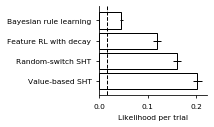

In [3]:
model_comparison('main')

### Variants of value-based SHT models (Fig S4B)

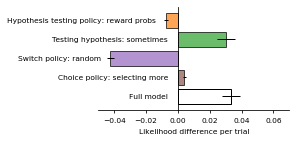

In [4]:
model_comparison('valueSHT')

## Model component contribution (Fig 5C,D)

In [5]:
action = 'main'

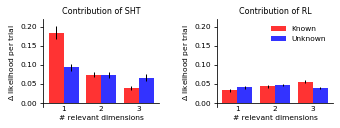

In [6]:
plt.rcParams.update({'font.size': 7.5})

if action == 'main':
    models = ['inferSerialHypoTesting_CountingValueBasedSwitchNoResetDecayEpsilonNoCost_FlexibleHypoAvg'] * 2
    refModels = ['featureRLwDecayNoCost', 'inferSerialHypoTesting_CountingRandomSwitchEpsilonNoCost_FlexibleHypoAvg']
elif action == 'full':
    models = ['inferSerialHypoTesting_CountingValueBasedSwitchNoResetDecayThresonTestSelectMoreNoCost_FlexibleHypoAvg'] * 2
    refModels = ['featureRLwDecayNoCost', 'inferSerialHypoTesting_CountingRandomSwitchThresonTestSelectMoreNoCost_FlexibleHypoAvg']

titles = ['Contribution of SHT', 'Contribution of RL']

# Load data
data, workerIds = load_data(expVersion='all', getWorkerIds=True)

for model in list(set(models + refModels)):
    dataThisModel = pd.read_csv('fittingResultsCVTrialLik/' + model + '_' + expVersion + '_allWorkers.csv')
    data[model + '_loglikelihood'] = dataThisModel[model + '_loglikelihood']

fig, axes = plt.subplots(1, len(models), figsize=(2.2*len(models)+0.35, 1.8), sharex=True)
dfANOVAList = []
for iM in range(len(models)):
    dfANOVAmodelList = []
    ax = axes[iM]
    model = models[iM]
    refModel = refModels[iM]
    for numRelevantDimensions in np.arange(len(DIMENSIONS)) + 1:
        for informed in [True, False]:
            dataCond = data[(data['numRelevantDimensions'] == numRelevantDimensions) & (data['informed'] == informed)].copy()
            lik_diff = [(np.exp(dataCond.groupby('workerId')[model + '_loglikelihood'].mean()) - np.exp(
                dataCond.groupby('workerId')[refModel + '_loglikelihood'].mean()))[workerId] for workerId in workerIds]  # groupby mean by default skips nan
            dfanova = pd.DataFrame({'dv': lik_diff, 'participant': workerIds, 'model': [iM]*len(workerIds), 
            'numRelevantDimensions': [numRelevantDimensions]*len(workerIds), 'informed': [informed]*len(workerIds)})
            dfANOVAList.append(dfanova)
            dfANOVAmodelList.append(dfanova)
            mean = np.mean(lik_diff)
            se = np.std(lik_diff) / np.sqrt(len(workerIds))
            p = ax.bar(x=numRelevantDimensions + (-0.2 if informed else 0.2), height=mean, width=0.4, yerr=se,
                        color='red' if informed else 'blue',
                        label=('Known' if informed else 'Unknown') if numRelevantDimensions == 1 else None, error_kw={'elinewidth':1}, alpha=.8)
    ax.set_xticks([1, 2, 3])
    ax.spines['bottom'].set_position('zero')
    sns.despine()
    ax.tick_params(axis='x', length=0, pad=3)
    ax.tick_params(axis='y', length=3)
    ax.set_xlabel(xlabel='# relevant dimensions', labelpad=3)
    ax.set_ylabel(ylabel='$\Delta$ likelihood per trial', labelpad=3)
    ax.set_title(titles[iM], pad=5, fontsize=8)
    ax.set_ylim([-0.01, 0.22])
    ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2])

    # anova
#     dfANOVA = pd.concat(dfANOVAmodelList)
#     aovrm = AnovaRM(data=dfANOVA, depvar='dv', subject='participant', within=['informed', 'numRelevantDimensions'], aggregate_func=np.nanmean)
#     print('Repeated measures ANOVA: ' + titles[iM] + '\n', aovrm.fit())
ax.legend(frameon=False)
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.show()

# anova
# dfANOVA = pd.concat(dfANOVAList)
# dfANOVA.to_csv('contribution_SHT_RL_CV_' + expVersion +'.csv')
# aovrm = AnovaRM(data=dfANOVA, depvar='dv', subject='participant', within=['informed', 'numRelevantDimensions', 'model'], aggregate_func=np.nanmean)
# print('Repeated measures ANOVA:\n', aovrm.fit())


## Alternative model fits broken down by game type (Fig S2A)

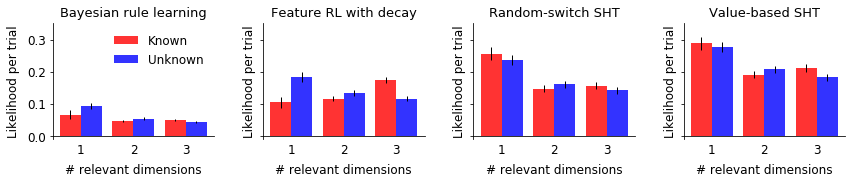

In [7]:
plt.rcParams.update({'font.size': 12})

models = [
    'myopicBayesianNoCost',
    'featureRLwDecayNoCost',
    'inferSerialHypoTesting_CountingRandomSwitchEpsilonNoCost_FlexibleHypoAvg',
    'inferSerialHypoTesting_CountingValueBasedSwitchNoResetDecayEpsilonNoCost_FlexibleHypoAvg',
]

modelLabel = {
    'myopicBayesianNoCost': 'Bayesian rule learning',
    'featureRLwDecayNoCost': 'Feature RL with decay',
    'inferSerialHypoTesting_CountingRandomSwitchEpsilonNoCost_FlexibleHypoAvg': 'Random-switch SHT',
    'inferSerialHypoTesting_CountingValueBasedSwitchNoResetDecayEpsilonNoCost_FlexibleHypoAvg': 'Value-based SHT',
}

fig, axes = plt.subplots(1, 4, figsize=(12, 2.7), sharey=True)

for i, model in enumerate(models):
    dataThisModel = pd.read_csv('fittingResultsCVTrialLik/' + model + '_' + expVersion + '_allWorkers.csv')
    data[model + '_loglikelihood'] = dataThisModel[model + '_loglikelihood']
    ax = axes[i]
    for numRelevantDimensions in np.arange(len(DIMENSIONS)) + 1:
        for informed in [True, False]:
            dataCond = data[(data['numRelevantDimensions'] == numRelevantDimensions) & (data['informed'] == informed)].copy()
            lik = [(np.exp(dataCond.groupby('workerId')[model + '_loglikelihood'].mean()))[workerId] for workerId in workerIds]  # groupby mean by default skips nan
            mean = np.mean(lik)
            se = np.std(lik) / np.sqrt(len(workerIds))
            p = ax.bar(x=numRelevantDimensions + (-0.2 if informed else 0.2), height=mean, width=0.4, yerr=se,
                        color='red' if informed else 'blue',
                        label=('Known' if informed else 'Unknown') if numRelevantDimensions == 1 else None, error_kw={'elinewidth':1}, alpha=.8)
    ax.set_xticks([1, 2, 3])
    ax.spines['bottom'].set_position('zero')
    sns.despine()
    ax.tick_params(axis='x', length=0, pad=7)
    ax.tick_params(axis='y', length=3)
    ax.set_xlabel(xlabel='# relevant dimensions', labelpad=7)
    ax.set_ylabel(ylabel='Likelihood per trial', labelpad=7)
    ax.set_ylim([-0.01, 0.35])
    ax.set_yticks([0, 0.1, 0.2, 0.3])
    ax.set_title(modelLabel[model], pad=7, fontsize=13)
    
axes[0].legend(frameon=False)
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()

## Model parameter estimates (Fig S2B)

In [8]:
fit = pd.read_csv('fittingResultsCollect/inferSerialHypoTesting_CountingValueBasedSwitchNoResetDecayThresonTestSelectMoreNoCost_FlexibleHypoAvg_all_L-BFGS-B.csv', header=0)

def normalize(h):
    return [h[0] * 9, h[1] * 27, h[2] * 27] / (h[0] * 9 + h[1] * 27 + h[2] * 27)

n_workers = fit['workerId'].nunique()
prior = [np.zeros((n_workers, 3)) for _ in range(4)]
for i, workerId in enumerate(fit['workerId'].unique()):
    wl = fit.loc[fit['workerId']==workerId, 'wl'].values
    wh = fit.loc[fit['workerId']==workerId, 'wh'].values
    p = [[1, wh, wh], [wl, 1, wh], [wl, wl, 1]]
    for d in range(3):
        prior[d][i, :] = np.array(normalize(p[d]))
prior[3] = (prior[0] + prior[1] + prior[2])/3

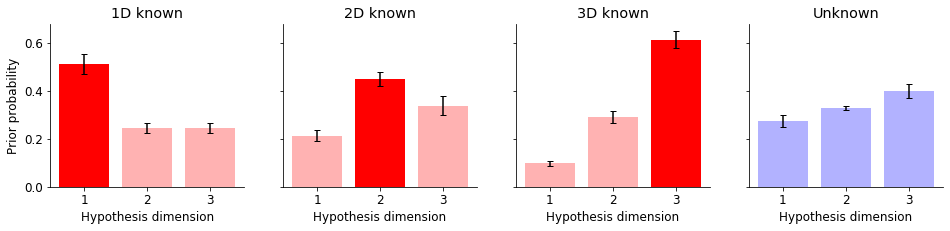

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(16,3), sharey=True)
for i, ax in enumerate(axes):
    mean = np.mean(prior[i], axis=0)
    sem = np.std(prior[i], axis=0) / np.sqrt(n_workers)
    for j in range(3):
        ax.bar(x=j, height=mean[j], color='r' if i < 3 else 'b', alpha=1 if i==j else .3)
    ax.errorbar(x=range(3), y=mean, yerr=sem, linestyle='none', color='k', capsize=3)
    ax.set_xticks(range(3))
    ax.set_xticklabels([1,2,3])
    ax.set_xlabel('Hypothesis dimension')
    ax.set_title(f'{i+1}D known' if i < 3 else 'Unknown')
axes[0].set_ylabel('Prior probability')
sns.despine()